In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Alex Mallen (atmallen@uw.edu)
"""

import numpy as np
import matplotlib.pyplot as plt
import torch
import random

from dpk import model_objs

seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# generate toy data with periodic uncertainty
t = np.linspace(0, 10_000 * np.pi, 1000)
mu_t = (1.2 + np.cos(t))
# sigma_t = 0.1 * (2 + 0.7 * np.sin(t)) ** 2
sigma_t = 0.2 * np.cos(t) + 0.5
data = np.random.normal(mu_t, sigma_t)
# normalize the data
scale = np.std(data)
loc = np.mean(data)
x = (data - loc) / scale
x = torch.Tensor(x.reshape(-1, 1))

periods = [200]
omegas = [2 * np.pi / p for p in periods]
# define a model
model_obj = model_objs.NormalNLL(x_dim=x.shape[1], num_freqs=len(periods), n=32)
# model_obj = model_objs.SkewNormalNLL(x_dim=x.shape[1], num_freqs=len(periods), n=32)
# model_obj = model_objs.DeterministicMSE(x_dim=x.shape[1], num_freqs=len(periods), n=512, n2=512)

[ Using Seed :  633  ]


In [2]:
K = 12  # number of points within a period of the error surface to use
two_pi_block = torch.arange(0, K).reshape(-1, 1) * 2 * np.pi / K
two_pi_block

tensor([[0.0000],
        [0.5236],
        [1.0472],
        [1.5708],
        [2.0944],
        [2.6180],
        [3.1416],
        [3.6652],
        [4.1888],
        [4.7124],
        [5.2360],
        [5.7596]])

In [3]:
norm = torch.distributions.normal.Normal(0, 1)
def norm_logcdf(z):

        if (z < -7).any():  # these result in NaNs otherwise
            # print("THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)")
            # https://stats.stackexchange.com/questions/106003/approximation-of-logarithm-of-standard-normal-cdf-for-x0/107548#107548?newreg=5e5f6365aa7046aba1c447e8ae263fec
            # I found this approx to be good: less than 0.04 error for all -20 < x < -5
            # approx = lambda x: -0.5 * x ** 2 - 4.8 + 2509 * (x - 13) / ((x - 40) ** 2 * (x - 5))
            ans = torch.where(z < -0.1, -0.5 * z ** 2 - 4.8 + 2509 * (z - 13) / ((z - 40) ** 2 * (z - 5)),
                                        -torch.exp(-z * 2) / 2 - torch.exp(-(z - 0.2) ** 2) * 0.2)
        else:
            ans = norm.cdf(z).log()

        return ans

In [4]:
from torch import optim

In [5]:
zeros_like = torch.zeros((x.shape[0], K))

0.36711476289061074
0 tensor(0.3671, dtype=torch.float64)


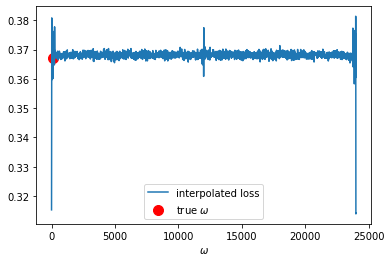

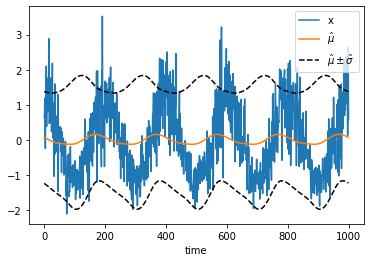

0.3203355692292745
1 tensor(0.3203, dtype=torch.float64)


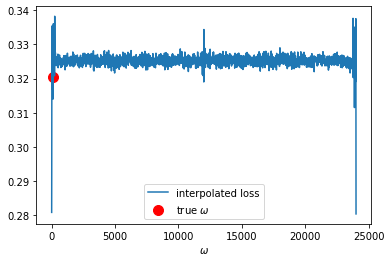

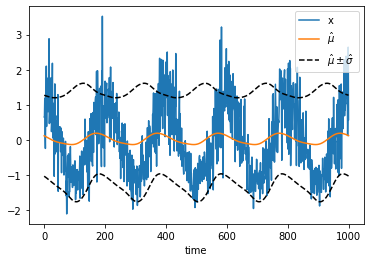

0.2812202976752965
2 tensor(0.2812, dtype=torch.float64)


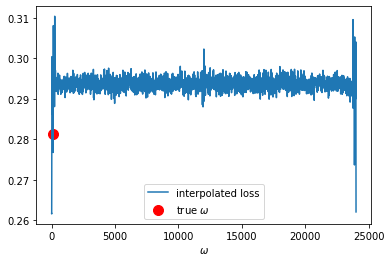

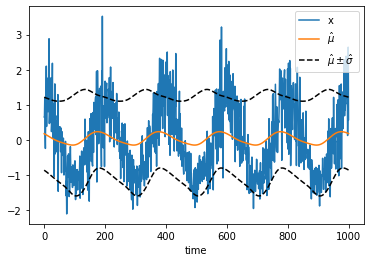

0.24937984296992594
3 tensor(0.2494, dtype=torch.float64)


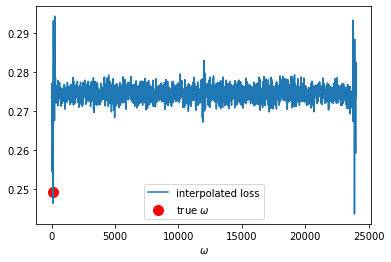

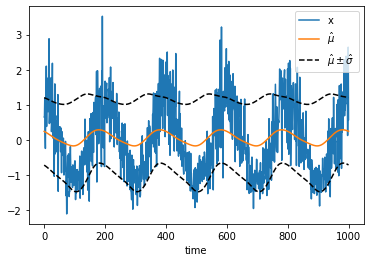

0.22300784722708056
4 tensor(0.2230, dtype=torch.float64)


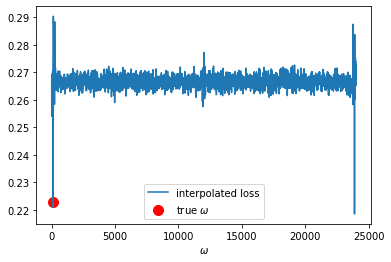

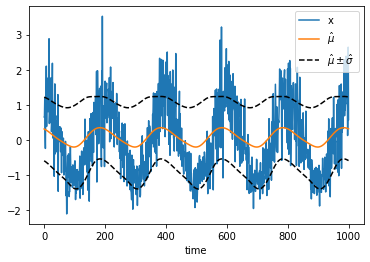

0.200078946110162
5 tensor(0.2001, dtype=torch.float64)


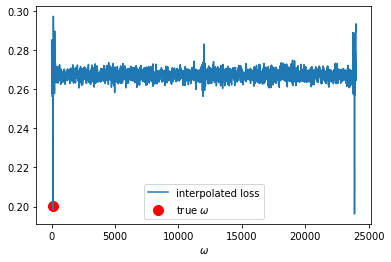

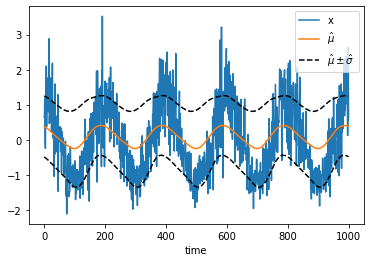

0.17908661413318716
6 tensor(0.1791, dtype=torch.float64)


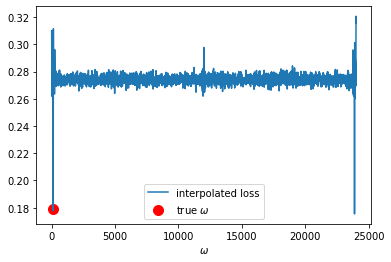

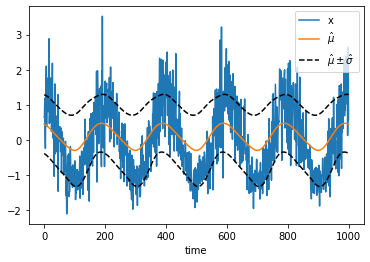

0.15905871408294642
7 tensor(0.1591, dtype=torch.float64)


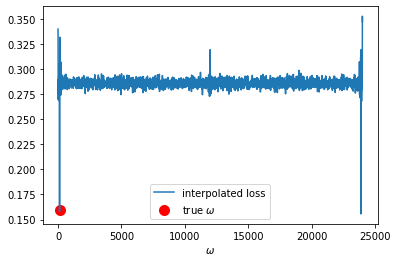

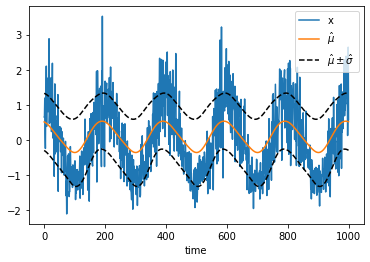

0.1393922189113248
8 tensor(0.1394, dtype=torch.float64)


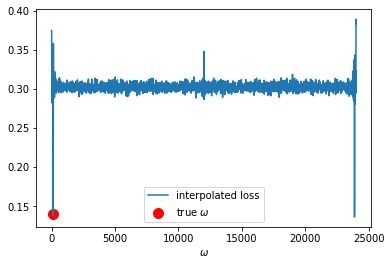

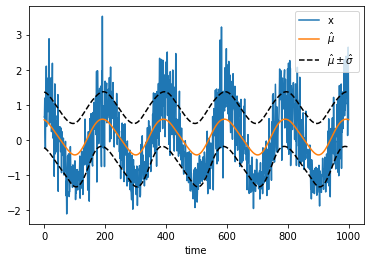

0.11975624737246297
9 tensor(0.1198, dtype=torch.float64)


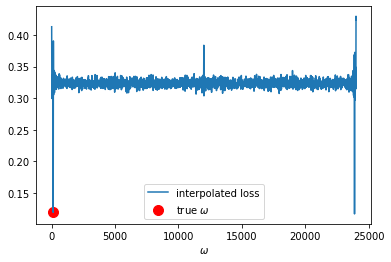

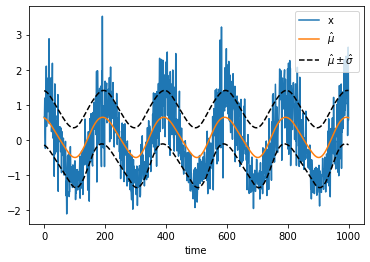

In [7]:
opt = optim.SGD(model_obj.parameters(), lr=7e-2)

train_losses = []
# train the model
for itr in range(10):
    opt.zero_grad()
    
    losses = torch.empty((K, x.shape[0]))

    inpts = torch.cat([torch.cos(two_pi_block)] * 2 + [torch.sin(two_pi_block)] * 2, -1)  # todo: generalize to more omegas
#     inpts = torch.cat([torch.cos(two_pi_block)] * 3 + [torch.sin(two_pi_block)] * 3, -1)  # todo: generalize to more omegas
#     inpts = torch.cat([torch.cos(two_pi_block)] + [torch.sin(two_pi_block)], -1)  # todo: generalize to more omegas
    inpts  # [cos_mu_w1, cos_mu_w2, cos_sigma_w1, cos_sigma_w2, cos_alpha_w1, cos_alpha_w2, sin...]
    m, s = model_obj.decode(inpts)
#     y, z, a = model_obj.decode(inpts)
#     xhat, = model_obj.decode(inpts)
    for tt in range(x.shape[0]):
        losses[:, tt] = ((x[tt, :] - m) ** 2 / (2 * s ** 2) + torch.log(s)).squeeze()
#         losses[:, tt] = ((x[tt, :] - y)**2 / (2 * z**2) + z.log() - norm_logcdf(a * (x[tt, :] - y) / z)).squeeze()
#         losses[:, tt] = (xhat.squeeze() - x[tt, :]) ** 2 / K
    
    # now each column of losses contains one period of the temporally local loss function
    
    
    # E = stitch together local errors using FFT
    complex_losses = torch.stack([losses.T, zeros_like], -1)
    losses_fft = torch.fft(complex_losses, signal_ndim=1)
    E_ft = torch.zeros((losses.shape[0] * losses.shape[1], 2), dtype=torch.float64)
    for t in range(1, losses.shape[1] + 1):
        E_ft[np.arange(K // 2) * t, :] += losses_fft[t-1, :K//2, :]  # what are the units of "frequency"? 1/idxs of E
    E_ft = torch.cat([E_ft, torch.flip(E_ft * torch.Tensor([[1, -1]]), dims=(0,))])[:-1]
    # (KT)^3
    # only comupte summands as needed
    # np.sum(E_ft[j, p] e^(-pi * i * j * omega0 in cycles per + -pi * i * p * omega1)
    E = torch.ifft(E_ft, signal_ndim=1)[:, 0]
    omega_idx = int(np.round(omegas[0] * E.shape[0] / (2 * np.pi)))
    E_star = E[omega_idx]
    loss = E_star  # - E.mean()
    print(loss.detach().numpy())

    grad = loss.backward()
    train_losses.append(loss.detach())
    print(itr, train_losses[-1])
    opt.step()
    
    %matplotlib inline
    plt.plot(E.detach(), label="interpolated loss")
    plt.scatter([omega_idx], [E_star.detach()], c="r", s=100, label="true $\omega$")
    plt.xlabel("$\omega$")
    plt.legend()
    plt.show()
    
    plt.plot(x, label="x")
    t = torch.arange(len(x))
    inpts = torch.stack([torch.cos(omegas[0] * t)] * 2 + [torch.sin(omegas[0] * t)] * 2).T  # todo: generalize to more omegas
#     inpts = torch.stack([torch.cos(omegas[0] * t)] * 3 + [torch.sin(omegas[0] * t)] * 3).T  # todo: generalize to more omegas
#     inpts = torch.stack([torch.cos(omegas[0] * t)] + [torch.sin(omegas[0] * t)]).T  # todo: generalize to more omegas
    params = model_obj.output(inpts)
    mean_hat = model_obj.mean(params)
    std_hat = model_obj.std(params)
    plt.plot(mean_hat, label="$\hat \mu$")
    plt.plot(mean_hat + std_hat, "--k", label="$\hat \mu \pm \hat \sigma$")
    plt.plot(mean_hat - std_hat, "--k")
    plt.xlabel("time")
    plt.legend()
    plt.show()

In [148]:
opt.zero_grad()
    
losses = torch.empty((K, x.shape[0]))

inpts = torch.cat([torch.cos(two_pi_block)] * 3 + [torch.sin(two_pi_block)] * 3, -1)  # todo: generalize to more omegas
#     inpts = torch.cat([torch.cos(two_pi_block)] + [torch.sin(two_pi_block)], -1)  # todo: generalize to more omegas
inpts  # [cos_mu_w1, cos_mu_w2, cos_sigma_w1, cos_sigma_w2, cos_alpha_w1, cos_alpha_w2, sin...]
y, z, a = model_obj.decode(inpts)
#     xhat, = model_obj.decode(inpts)
for tt in range(x.shape[0]):
    losses[:, tt] = ((x[tt, :] - y)**2 / (2 * z**2) + z.log() - norm_logcdf(a * (x[tt, :] - y) / z)).squeeze()
#         losses[:, tt] = (xhat.squeeze() - x[tt, :]) ** 2 / K

In [150]:
complex_losses = torch.stack([losses.T, zeros_like], -1)
losses_fft = torch.fft(complex_losses, signal_ndim=1)
E_ft = torch.zeros((losses.shape[0] * losses.shape[1], 2), dtype=torch.float64)
for t in range(1, losses.shape[1] + 1):
    E_ft[np.arange(K // 2) * t, :] += losses_fft[t-1, :K//2, :]  # what are the units of "frequency"? 1/idxs of E

In [156]:
E_ft.shape

torch.Size([23999, 2])

In [155]:
torch.sum(torch.isnan(E_ft))

tensor(312)

In [151]:
E_ft = torch.cat([E_ft, torch.flip(E_ft * torch.Tensor([[1, -1]]), dims=(0,))])[:-1]
E = torch.ifft(E_ft, signal_ndim=1)[:, 0]
omega_idx = int(np.round(omegas[0] * E.shape[0] / (2 * np.pi)))
E_star = E[omega_idx]
loss = E_star  # - E.mean()
print(loss.detach().numpy())

nan


In [134]:
params

(array([[ 1.2993203 ],
        [ 1.2936934 ],
        [ 1.2869567 ],
        [ 1.2791173 ],
        [ 1.2701837 ],
        [ 1.2601651 ],
        [ 1.2490717 ],
        [ 1.2369155 ],
        [ 1.2237092 ],
        [ 1.2094672 ],
        [ 1.1942054 ],
        [ 1.177941  ],
        [ 1.160693  ],
        [ 1.1424822 ],
        [ 1.1233308 ],
        [ 1.1032628 ],
        [ 1.0823044 ],
        [ 1.0604829 ],
        [ 1.0378276 ],
        [ 1.0143698 ],
        [ 0.990142  ],
        [ 0.96517813],
        [ 0.93951356],
        [ 0.9131855 ],
        [ 0.88623106],
        [ 0.8586893 ],
        [ 0.83059907],
        [ 0.8019998 ],
        [ 0.7729316 ],
        [ 0.74343395],
        [ 0.7135461 ],
        [ 0.68330663],
        [ 0.6527531 ],
        [ 0.62192214],
        [ 0.5908493 ],
        [ 0.55956805],
        [ 0.52811027],
        [ 0.4965062 ],
        [ 0.4647841 ],
        [ 0.4329698 ],
        [ 0.4010871 ],
        [ 0.36915794],
        [ 0.337202  ],
        [ 0

In [9]:
%matplotlib notebook
plt.figure(figsize=(12, 4))
plt.plot(E_ft.detach().numpy())
# plt.ylim([-12, 12])
plt.show()

<IPython.core.display.Javascript object>

In [87]:
opt.zero_grad()
    
losses = torch.empty((K, x.shape[0]))

In [88]:

inpts = torch.cat([torch.cos(two_pi_block)] * 3 + [torch.sin(two_pi_block)] * 3, -1)  # todo: generalize to more omegas
inpts  # [cos_mu_w1, cos_mu_w2, cos_sigma_w1, cos_sigma_w2, cos_alpha_w1, cos_alpha_w2, sin...]
y, z, a = model_obj.decode(inpts)
#     xhat, = model_obj.decode(inpts)
for tt in range(x.shape[0]):
    losses[:, tt] = ((x[tt, :] - y)**2 / (2 * z**2) + z.log() - norm_logcdf(a * (x[tt, :] - y) / z)).squeeze()
#         losses[:, tt] = (xhat.squeeze() - x[tt, :]) ** 2 / K


In [ ]:
# E = stitch together local errors using FFT
complex_losses = torch.stack([losses.T, zeros_like], -1)
losses_fft = torch.fft(complex_losses, signal_ndim=1)
E_ft = torch.zeros((losses.shape[0] * losses.shape[1], 2), dtype=torch.float64)
for t in range(1, losses.shape[1] + 1):
    E_ft[np.arange(K // 2) * t, :] += losses_fft[t-1, :K//2, :]  # what are the units of "frequency"? 1/idxs of E
E_ft = torch.cat([E_ft, torch.flip(E_ft * torch.Tensor([[1, -1]]), dims=(0,))])[:-1]
E = torch.ifft(E_ft, signal_ndim=1)[:, 0]
omega_idx = int(np.round(omegas[0] * E.shape[0] / (2 * np.pi)))
E_star = E[omega_idx]
loss = E_star  # - E.mean()
print(loss.detach().numpy())

In [107]:
def reconstruct(errors):
    e_fft = np.fft.fft(errors)
    E_ft = np.zeros(errors.shape[0]*K, dtype=np.complex64)

    for t in range(1,e_fft.shape[0]+1):
        E_ft[np.arange(K//2)*t] += e_fft[t-1,:K//2]

    E_ft = np.concatenate([E_ft, np.conj(np.flip(E_ft))])[:-1]
    E = np.real(np.fft.ifft(E_ft))
    return E, E_ft

In [102]:
losses.shape

torch.Size([12, 1000])

In [226]:
errors = losses.T.detach()
e_fft = np.fft.fft(errors)
EE_ft = np.zeros(errors.shape[0]*K, dtype=np.complex64)

for t in range(1,e_fft.shape[0]+1):
    EE_ft[np.arange(K//2)*t] += e_fft[t-1,:K//2]

EE_ft = np.concatenate([EE_ft, np.conj(np.flip(EE_ft))])[:-1]
EE = np.real(np.fft.ifft(EE_ft))

In [227]:
e_fft.shape, losses_fft.shape

((1000, 12), torch.Size([1000, 12, 2]))

In [229]:
EE_ft.shape, E_ft.shape

((23999,), torch.Size([24000, 2]))

In [222]:
EE, E

(array([0.60256482, 0.60867274, 0.62126004, ..., 0.63344935, 0.61528097,
        0.60463549]),
 tensor([2.5965, 2.6339, 2.7014,  ..., 2.7989, 2.7048, 2.6220],
        dtype=torch.float64, grad_fn=<SelectBackward>))

In [10]:
%matplotlib notebook
plt.plot(E)

<IPython.core.display.Javascript object>

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [40]:
yy

tensor([0.3698], grad_fn=<AddBackward0>)

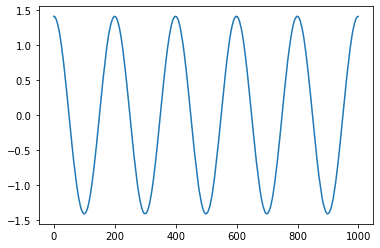

In [27]:
plt.plot(x)

In [14]:
model_obj

SkewNormalNLL(
  (l1_mu): Linear(in_features=2, out_features=32, bias=True)
  (l2_mu): Linear(in_features=32, out_features=64, bias=True)
  (l3_mu): Linear(in_features=64, out_features=1, bias=True)
  (l1_sig): Linear(in_features=2, out_features=32, bias=True)
  (l2_sig): Linear(in_features=32, out_features=64, bias=True)
  (l3_sig): Linear(in_features=64, out_features=1, bias=True)
  (l1_a): Linear(in_features=2, out_features=32, bias=True)
  (l2_a): Linear(in_features=32, out_features=64, bias=True)
  (l3_a): Linear(in_features=64, out_features=1, bias=True)
)

In [25]:
arr.shape

(1, 100, 2)

In [43]:
t = np.linspace(0, 2 * np.pi, 100)
arr = np.stack([np.cos(t) * 0] * 3 + [np.sin(t)] * 3).T
inpts = torch.Tensor(arr)
y, z, a = model_obj.decode(inpts)

<IPython.core.display.Javascript object>


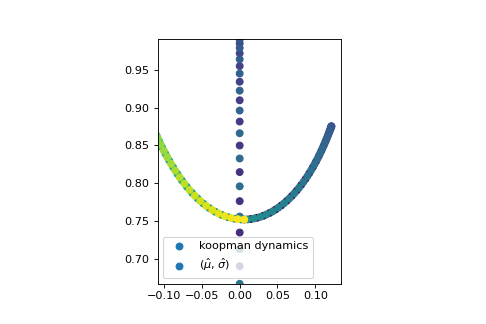

In [46]:
%matplotlib notebook
plt.scatter(arr[:, 0], arr[:, 3], c=t, label="koopman dynamics")
plt.scatter(y.detach(), z.detach(), c=t, label="($\hat \mu$, $\hat \sigma$)")
# plt.plot(arr, z.detach(), label="z")
# plt.plot(arr, a.detach(), label="a")
plt.legend()
plt.gca().set_aspect(1)

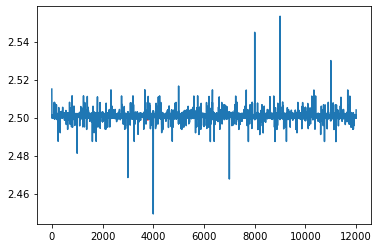

In [39]:
%matplotlib notebook
plt.plot(E.detach())
plt.scatter([omega_idx], [E_star.detach()], c="r", s=50)

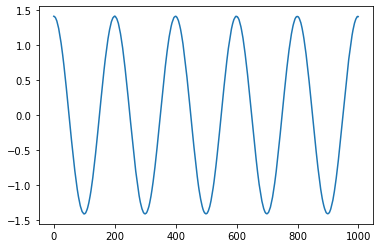

In [52]:
plt.plot(x)

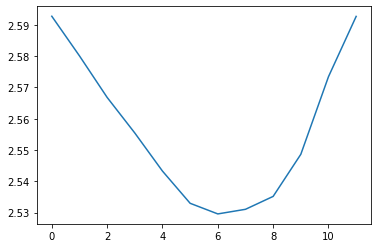

In [167]:
plt.plot(losses[:, 0].detach())  # when t=0 the loss should not depend on w, because wt = 0 for all w

In [ ]:
# plot
plt.plot(x_hat, "tab:orange", label="$\hat x$")
plt.plot(data, "tab:blue", label="$x$")
plt.plot(x_hat + std_hat, "--k", label="$\hat x \pm \hat \sigma$")
plt.plot(x_hat - std_hat, "--k")
plt.xlim([9_900, 10_100])
plt.legend()
plt.show()

plt.plot(mu_t, label="$\mu$")
plt.plot(x_hat, ":k", label="$\hat \mu$")
plt.plot(sigma_t, label="$\sigma$")
plt.plot(std_hat, "--k", label="$\hat \sigma$")
plt.xlim([50_900, 51_100])
plt.legend()
plt.show()

TypeError: linspace() got an unexpected keyword argument 'endpoint'

In [3]:
import torch

In [4]:
ttt = torch.tensor([1])

In [5]:
ttt.type?

Docstring:
type(dtype=None, non_blocking=False, **kwargs) -> str or Tensor
Returns the type if `dtype` is not provided, else casts this object to
the specified type.

If this is already of the correct type, no copy is performed and the
original object is returned.

Args:
    dtype (type or string): The desired type
    non_blocking (bool): If ``True``, and the source is in pinned memory
        and destination is on the GPU or vice versa, the copy is performed
        asynchronously with respect to the host. Otherwise, the argument
        has no effect.
    **kwargs: For compatibility, may contain the key ``async`` in place of
        the ``non_blocking`` argument. The ``async`` arg is deprecated.
Type:      builtin_function_or_method


In [6]:
from numpy.fft import fftshift, ifftshift, ifftn, fftfreq, fftn, rfftn, irfftn

In [58]:
# Lft = np.array([range(i + 1, i + 4) for i in range(10, 90, 10)])

T = 10
K = 6
inpts = np.arange(K*T) * 2 * np.pi / (K * T)
mesh_t, mesh1, mesh2 = np.meshgrid(np.arange(1, T + 1), inpts, inpts, indexing="ij")
local_losses = np.cos(mesh_t * (mesh1 + mesh2))
L = np.array([local_losses[0, 0:K*T:T, 0:K*T:T] for t in range(1, T+1)])
Lft = fftshift(fftn(L, axes=(1, 2)), axes=(1, 2))  # if I don't do fftshift, I can think of the frequencies as n/N for n = 0:N-13 (not when doing zero padding)
Eft = np.zeros((T * K, T * K), dtype=complex)
for t in range(1, T + 1):
    # Eft[0:K*t:t, 0:K*t:t] += Lft[t - 1, :, :]
    # upper left quadrant
    Eft[0:(K//2)*t:t, 0:(K//2)*t:t] += Lft[t-1, :K//2, :K//2]
    # lower left quadrant
    Eft[(K//2)*t:K*t:t, 0:(K//2)*t:t] += Lft[t-1, K//2:K, :K//2]
    # upper right quadrant
    Eft[0:(K//2)*t:t, (K//2)*t:K*t:t] += Lft[t-1, :K//2, K//2:K]
    # lower right quadrant
    Eft[(K//2)*t:K*t:t, (K//2)*t:K*t:t] += Lft[t-1, K//2:K, K//2:K]

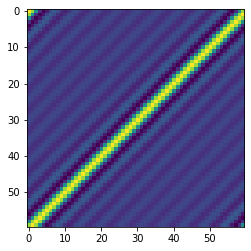

In [34]:
actual_E = np.sum(local_losses, axis=0)
plt.imshow(actual_E)

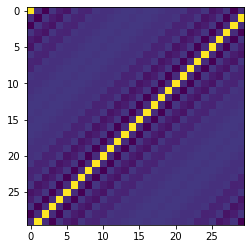

In [95]:
E = ifftn(Eft, axes=(0, 1))
plt.imshow(np.real(E))

In [55]:
E, actual_E

(array([[ 1.47911420e-33+1.20323673e-18j,  1.80989912e-02-5.68783714e-04j,
          3.19771773e-02-2.01183347e-03j, ...,
         -3.87198380e-02-3.66010231e-03j, -3.19771773e-02-2.01183347e-03j,
         -1.80989912e-02-5.68783714e-04j],
        [ 1.80989912e-02-5.68783714e-04j,  3.19771773e-02-2.01183347e-03j,
          3.87198380e-02-3.66010231e-03j, ...,
         -3.19771773e-02-2.01183347e-03j, -1.80989912e-02-5.68783714e-04j,
         -2.39018341e-17+9.26881643e-18j],
        [ 3.19771773e-02-2.01183347e-03j,  3.87198380e-02-3.66010231e-03j,
          3.75676598e-02-4.74589912e-03j, ...,
         -1.80989912e-02-5.68783714e-04j, -1.67745644e-17+2.88276706e-18j,
          1.80989912e-02-5.68783714e-04j],
        ...,
        [-3.87198380e-02-3.66010231e-03j, -3.19771773e-02-2.01183347e-03j,
         -1.80989912e-02-5.68783714e-04j, ...,
         -1.92074036e-02-3.66400820e-03j, -3.00236726e-02-4.75528258e-03j,
         -3.75676598e-02-4.74589912e-03j],
        [-3.19771773e-02-2.

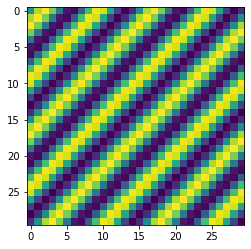

In [293]:
plt.imshow(local_losses[3, :, :])

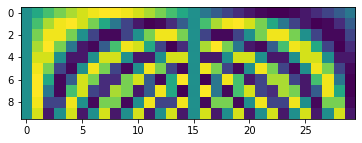

In [24]:
plt.imshow(local_losses[:, :, 0])

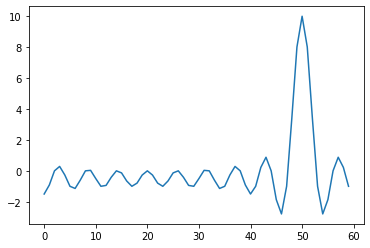

In [50]:
plt.plot(actual_E[:, 10])

In [97]:
w = (0.2, 0.15)
actual_E[int(K * T * w[0]), int(K * T * w[1])]

-0.49999999999999856

In [51]:
w0 = 0.5
w1 = 0.2
losses = np.array([], dtype=complex)
# each element is what freq is represented by the corresponding element in a 1D L
freqs = np.array([fftshift(fftfreq(K)) * t / T for t in range(1, T + 1)])
F0 = np.array([np.meshgrid(freqs[t], freqs[t], indexing="ij")[0] for t in range(T)])
F1 = np.array([np.meshgrid(freqs[t], freqs[t], indexing="ij")[1] for t in range(T)])

In [52]:
M = np.exp(complex("j") * 2 * np.pi * (F0 * w0 + F1 * w1))
loss = np.sum(Lft * M) / (T*K)**2 # np.sum(np.prod(np.prod(L * M, axis=1), axis=1))
loss

(0.08995665438304855+6.537980033903699e-18j)

In [133]:
# M is a matrix you multiply by Lft to get E
losses = np.zeros((actual_E.shape), dtype=complex)
# each element is what freq is represented by the corresponding element in a 1D L
freqs = np.array([fftshift(fftfreq(K)) * t / T for t in range(1, T + 1)])
F0 = np.array([np.meshgrid(freqs[t], freqs[t], indexing="ij")[0] for t in range(T)])
F1 = np.array([np.meshgrid(freqs[t], freqs[t], indexing="ij")[1] for t in range(T)])
for i, w0 in enumerate(np.arange(K * T)):
    for j, w1 in enumerate(np.arange(K * T)):
        M = np.exp(complex("j") * 2 * np.pi * (F0 * w0 + F1 * w1))
        loss = np.sum(Lft * M) / (T*K)**2  # np.sum(np.prod(np.prod(L * M, axis=1), axis=1))
        losses[i, j] = loss

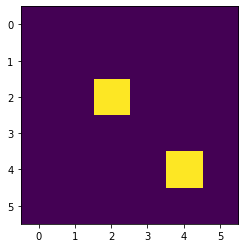

In [134]:
plt.imshow(np.real(Lft[0, :, :]))

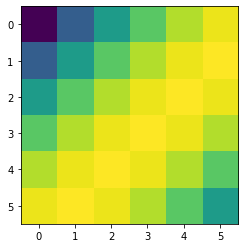

In [135]:
plt.imshow(np.real(M[0, :, :]))

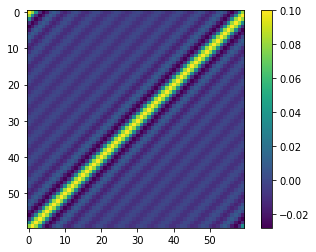

In [138]:
plt.imshow(np.real(losses))
plt.colorbar()

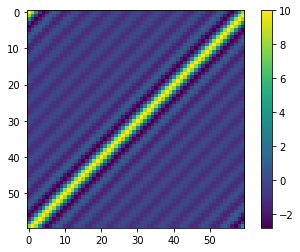

In [139]:
plt.imshow(np.real(actual_E))
plt.colorbar()

In [102]:
np.sum(np.prod(np.prod(L * M, axis=1), axis=1))

(-0.014967366505551038-0.016353020815623905j)

In [107]:
E[3, 3]

(0.005030353747284707+0.005394584071452477j)

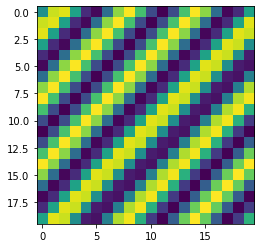

In [168]:
n = 20
x, y = np.meshgrid(np.arange(n), np.arange(n), indexing="ij")
s = np.sin(x + y)
plt.imshow(s)

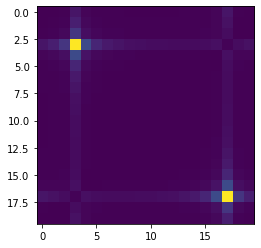

In [169]:
sft = fftn(s, axes=(0, 1))
plt.imshow(np.abs(sft))

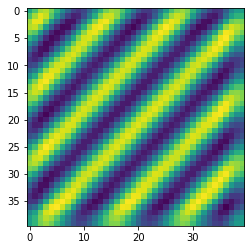

In [174]:
# whats the difference between them?
sft2 = np.zeros((2 * n, 2 * n), dtype=complex)
# sft2[:n, :n] = sft
sft2[0:n // 2, :n // 2] = sft[:n // 2, :n // 2]
sft2[-(n // 2):, -(n // 2):] = sft[-(n // 2):, -(n // 2):]
s2 = ifftn(sft2, axes=(0, 1))
plt.imshow(np.real(s2))

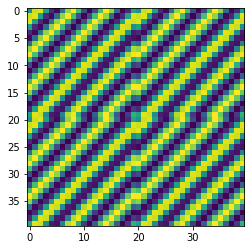

In [179]:
sft_dup = np.zeros((2 * n, 2 * n), dtype=complex)
sft_dup[::2, ::2] = sft
s_dup = ifftn(sft_dup, axes=(0, 1))
plt.imshow(np.real(s_dup))